# 1. Import & Setting

### 1-1) Path Setting

In [1]:
import os
project_path = "C:/workspace/Bus Project"
os.chdir(project_path)

### 1-2) Import

In [2]:
import datetime
import numpy as np
import pandas as pd
import multiprocessing
from functools import partial
from multiprocessing import Pool

import bus.analyzer as anz

In [3]:
import os
import datetime
import requests
import numpy as np
import pandas as pd
import multiprocessing
from tqdm import tqdm
from pyarrow import csv
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
import xml.etree.ElementTree as elemTree
from multiprocessing import Pool

### 1-3) 한글 폰트 설정

In [4]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 2) Library

### 2-1) Pandas Analysis Library

#### * 이용량 분석

In [ ]:
"""
* function        : object에 대한 subject의 이용량을 계산하여 반환
* s_df(subject_df): 이용자 정보를 담는 테이블
* o_df(object_df) : 타켓 정보를 담는 테이블
* u_df(usage_df)  : subject의 object이용 정보를 담는 테이블
* s_id(subject_id): subject_df의 키 컬럼 명시
* o_id(object_id) : object_df의 키 컬럼 명시 
* column : 이용량을 나타내는 결과 컬럼 네임 명시

* 매개변수에 대한 const 설정 보장(수정 안함)
"""
def get_usage(s_df, o_df, u_df, column = "usage",
                                     s_id = "subject_id", o_id="object_id"):
    # 필요한 컬럼 추출 및 결측치 제거
    o_df = o_df.copy()[[o_id]].dropna()
    s_df = s_df.copy()[[s_id]].dropna()
    u_df = u_df.copy()[[s_id, o_id]].dropna()
    
    # 원하는 정보만 추출 - u_df에서 s_df에 존재하는 id와 연관된 데이터만 추출한다.
    u_df = pd.merge(u_df, s_df, on=s_id, how="inner")
    
    # 이용량 계산
    u_df = u_df.groupby(by=o_id).count().reset_index().rename(columns={s_id:column})
    
    # 전체 object에 대해 이용량 컬럼 생성
    o_df = pd.merge(o_df, u_df, on=o_id, how="outer").fillna(0)

    return o_df

### 2-2) Bus Analysis Library

#### * 정류장 이용량 분석

In [118]:
"""
* function: 이용자가 정류장에 승 하차를 몇번했는 지를 카운트 하여 원하는 컬럼명으로 생성
* orders  : 작업 내용 명세 리스트
            - form [order, order, ..., order]
            
* order   : 작업 내용 명세
            - form: = [user, behavior, column]
            
* user    : [ "total" | "tourist" | "remainder" ]
* behavior: [ "geton" | "getoff" ]
* column  : string
"""
def analyze_station_usage(station_df, user_df, usage_df, orders):
    # order에 대한 실직적인 데이터 저장___________________________________________________
    subject_dic = {"total": user_df, 
                   "tourist": user_df[user_df["tourist"] == True], 
                   "remainder":user_df[user_df["tourist"] == False]}
    
    usage_dic   = {"geton": usage_df.rename(columns={"geton_station_id":"station_id"}), 
                   "getoff":usage_df.rename(columns={"getoff_station_id":"station_id"})}
    
    # order수행___________________________________________________________________________
    for order in orders: 
        # get_usage()에 대한 파라미터 세팅________________________________________________
        user, behavior, column = order
        s_df = subject_dic[user]   # user에 따라 전체 이용자, 관광객 이용자, 나머지 이용자를 추출
        o_df = station_df          # 항상 station_df로 고정 
        u_df = usage_dic[behavior] # behavior에 따라 승차 또는 하차 데이터 컬럼을 station_id로 변경 for using get_usage()
        
        # get_usag() 수행 후 결과 반영____________________________________________________
        result_df = get_usage(s_df, o_df, u_df, column = column, s_id="user_id", o_id="station_id")
        station_df[column] = result_df[column]
        
    return station_df

# 3. 이용자 & 정류장 추출

### 3-1) 이용데이터 로딩

In [5]:
# 데이터 기간 설정
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 8, 29)

# 로딩할 파일 명 리스트 생성
input_path_list = anz.make_input_path(start_date, end_date)

# 전체 데이터 로딩 (multi)
usage_df = anz.parallel_load_total_usage_df(input_path_list)

### 3-2) 정류장 추출 & 분석

#### 3-2-1) 전체 이용 정류장 추출

In [135]:
def create_station_df(usage_df):
    # 추출할 컬럼 리스트
    station_columns = ['station_id', 'station_name', 'station_longitude', 'station_latitude']
    
    # 승차, 하차 데이터 추출을 위한 컬럼 네임 변경 데이터 생성__________________________________________________
    geton_rename_dict = {}
    getoff_rename_dict = {}
    geton_station_columns = ['geton_station_id', 'geton_stataion_name', 'geton_station_longitude', 'geton_station_latitude']
    getoff_station_columns = ['getoff_station_id', 'getoff_station_name', 'getoff_station_longitude', 'getoff_station_latitude']
    for i, column in enumerate(station_columns):
        geton_rename_dict[geton_station_columns[i]] = column
        getoff_rename_dict[getoff_station_columns[i]] = column
    
    # 데이터 추출 (승차, 하차 개별)_____________________________________________________________________________
    geton_station_df = usage_df[geton_station_columns].drop_duplicates().rename(columns = geton_rename_dict).dropna()
    getoff_station_df = usage_df[getoff_station_columns].drop_duplicates().rename(columns = getoff_rename_dict).dropna()
    
    # 승차, 하차 데이터 병합____________________________________________________________________________________
    station_df = pd.concat([geton_station_df, getoff_station_df]).drop_duplicates()
    
    # 예외처리 - 하나의 id에 대하여 여러 경도, 위도 존재________________________________________________________
    id_count_df = pd.DataFrame(station_df['station_id'].value_counts()).reset_index().rename(columns = {'index':'station_id', 'station_id':'count'})
    exception_df = id_count_df[id_count_df['count'] >1]
    exception_id_list = list(exception_df['station_id'])
    for exception_id in exception_id_list:
        temp_df = station_df[station_df['station_id'] == exception_id]
        station_df = station_df[station_df['station_id'] != exception_id]
        station_df = pd.concat([station_df, temp_df.head(1)])
        
    return station_df

#정류장 추출
station_df = anz.create_station_df(usage_df)

# 정렬
station_df = station_df.sort_values(by="station_id")

# 인덱스 초기화
station_df.reset_index(inplace = True)
del station_df["index"]

# 추출 결과 출력
print("추출된 정류장 개수: ",len(station_df))

추출된 정류장 개수:  3654


#### 3-2-2) 주소컬럼 추가

In [ ]:
# 정류장 주소 추가 API 사용 함수
def get_address(loc_x, loc_y, mean_x = 126.531891, mean_y = 33.399409, 
                key = "E20F6493-C13D-3F6F-AC90-D5BB2F239901",
                url_form = "http://api.vworld.kr/req/address?service=address&request=getAddress&version=2.0&crs=epsg:4326&point={},{}&format=xml&type=both&zipcode=true&simple=false&key={}"):

    # 위도, 경도 반올림 for 빠른 예외처리를 위해
    loc_x = round(float(loc_x), 7)
    loc_y = round(float(loc_y), 7)
    
    url = url_form.format(loc_x, loc_y, key)
    response = requests.get(url)
    tree = elemTree.fromstring(response.text)
    
    try:
        #response(xml)로 부터 주소 데이터 추출
        address = tree.find("result").find("item[1]").find("text").text
    
    except: # 위도 경도가 바다 위에 있는 경우 API 결과의 주소 데이터가 비어있다.
#         print("현재 좌표: ",(loc_x, loc_y), "주소 없음")
        x_left = str(int(loc_x))
        y_left = str(int(loc_y))
        
        if mean_x < loc_x:
            x_right = str((int(loc_x*100000)-2)%100000)
        else:
            x_right = str((int(loc_x*100000)+2)%100000)
            
        if mean_y < loc_y:
            y_right = str((int(loc_y*100000)-2)%100000)
        else:
            y_right = str((int(loc_y*100000)+2)%100000)
            
        loc_x = float(x_left+"."+x_right)
        loc_y = float(y_left+"."+y_right)
        return get_address(loc_x, loc_y)
            
    return address

def set_station_address_column(df, longitude_column="station_longitude", latitude_columns = "station_latitude", result_column = "station_address"):
    df = pd.DataFrame.copy(df)
    
    if result_column in df.columns:# result_columns이 이미 존재한다면 제거
        del df[column]
        
    df[result_column] = ""
    for i in tqdm(df.index):
        df.loc[i, column] = get_address(float(df.loc[i, longitude_column]), float(df.loc[i, latitude_columns]))
    
    return df

station_df = set_station_address_column(station_df)

 66%|███████████████████████████████████████████████████▏                          | 2398/3654 [02:49<01:27, 14.31it/s]

In [ ]:
# analyze_station_usage()에 대한 작업 내용 파라미터 셋
orders = [["total",   "geton",  "total_geton_count"],
          ["total",   "getoff", "total_getoff_count"]]

# 전체 이용자에 대한 정류장별 이용량 분석 수행
station_df = analyze_station_usage(station_df, user_df, usage_df, orders)

# storing
station_df.to_csv("data/analysis/station_df.csv", encoding="CP949", index=False)

In [7]:
station_df = anz.load_station_df()

### 3-3) 출입정류장 추출

In [8]:
def extract_access_stations(station_df):
    station_df = station_df.copy()
    station_df['access_station_flag'] = station_df['station_name'].apply(lambda x : "airport" if str(x).find("제주국제공항") != -1 else "harbor" if (
                                                             bool(str(x).find("국제여객터미널") != -1)| 
                                                             bool(str(x).find("제주연안여객터미넡") != -1)| 
                                                             bool(str(x).find("제4부두")        != -1)|
                                                             bool(str(x).find("제6부두")        != -1)|
                                                             bool(str(x).find("임항로")         != -1)|
                                                             bool(str(x).find("제주해양경찰서") != -1)) else "other")
    station_df = station_df[station_df["access_station_flag"] != "other"]
    station_df.sort_values(by="station_id", inplace=True)
    station_df.reset_index(inplace = True)
    del station_df["access_station_flag"]
    del station_df["index"]
    return station_df

access_station_df = extract_access_stations(station_df)
access_station_df = access_station_df[["station_id", "station_name", "station_address", "station_longitude", "station_latitude"]]
access_station_df

,station_id,station_name,station_address,station_longitude,station_latitude
0,216.0,제주해양경찰서,제주특별자치도 제주시 건입동 918-13,126.53970,33.52042
1,218.0,제4부두,제주특별자치도 제주시 건입동 918-13,126.53818,33.52018
2,621.0,제주국제공항입구,제주특별자치도 제주시 용담이동 1588-5,126.49647,33.50461
3,638.0,제주국제공항(구제주방면),제주특별자치도 제주시 용담이동 1462-1,126.49345,33.50661
4,1355.0,제주국제공항(신제주방면),제주특별자치도 제주시 용담이동 1984-5,126.49275,33.50610
5,1579.0,제주국제공항(600번),제주특별자치도 제주시 용담이동 1984-5,126.49252,33.50577
6,2959.0,임항로,제주특별자치도 제주시 건입동 918-13,126.54028,33.52071
7,2972.0,제주국제공항(종점),제주특별자치도 제주시 용담이동 1462,126.49356,33.50572
8,2973.0,제주국제공항,제주특별자치도 제주시 용담이동 1972-2,126.49455,33.50450
9,3112.0,제6부두,제주특별자치도 제주시 건입동 908-26,126.54445,33.52240


### 3-3) - 이용자 추출 & 분석

In [119]:
# 유저 목록 생성
user_df = anz.create_user_df(usage_df)

In [120]:
# 이용 날짜 분석 완료
user_df = anz.analyze_usage_date(user_df, usage_df)

In [9]:
# 이용 횟수 분석 완료
user_df = anz.analyze_usage_num(user_df, usage_df)

In [ ]:
# 이용 비율 분석 완료
user_df = anz.parallel_analyze_usage_ratio(user_df)

In [ ]:
# 출발, 도작지 분석 완료
user_df = anz.analyze_start_end(user_df, usage_df)

### 3-4) 관광객 추출

In [10]:
# HAND WORK - "station_df.csv"를 보고 직접 관광 관련 정류장 컬럼을 삽입하고
# "tour_station_df.csv"로 저장
station_df = pd.read_csv("data/analysis/tour_station_df.csv", low_memory=False, encoding = "cp949") #, dtype=dtype)
tour_station_df = station_df[station_df["tour_station_flag"] == True]
tour_station_df = tour_station_df[tour_station_df['total_usage'] >= 150]
tour_station_df

,station_id,station_name,station_longitude,station_latitude,station_address,tour_geton_usage,regident_geton_usage,tour_getoff_usage,regident_getoff_usage,total_usage,tour_station_flag
14,280.0,동문로터리(동문시장),126.52795,33.51295,제주특별자치도 제주시 일도일동 1148-2,1402.0,99019.0,1993.0,34434.0,136848.0,True
15,279.0,동문로터리(동문시장),126.52706,33.51315,제주특별자치도 제주시 일도일동 1478-9,4595.0,73110.0,1170.0,51535.0,130410.0,True
44,325.0,관덕정,126.52088,33.51322,제주특별자치도 제주시 삼도이동 995-1,2751.0,49007.0,726.0,23737.0,76221.0,True
50,186.0,은남동,126.49090,33.48582,제주특별자치도 제주시 연동 273,1884.0,51044.0,263.0,16912.0,70103.0,True
57,222.0,삼양동주민센터,126.58567,33.52128,제주특별자치도 제주시 삼양이동 2186-1,380.0,48506.0,272.0,18571.0,67729.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2869,3467.0,번개과학체험관,126.58627,33.28918,제주특별자치도 서귀포시 토평동 1890-8,3.0,65.0,6.0,83.0,157.0,True
2873,3393.0,제지기오름,126.61105,33.24549,제주특별자치도 서귀포시 하효동 1425-1,6.0,113.0,2.0,34.0,155.0,True
2876,2876.0,송악펜션단지,126.29235,33.21229,제주특별자치도 서귀포시 대정읍 상모리 73-1,4.0,77.0,13.0,60.0,154.0,True
2883,1049.0,거문오름입구,126.70900,33.45304,제주특별자치도 제주시 조천읍 선흘리 1848-3,1.0,23.0,29.0,99.0,152.0,True


In [11]:
def insert_count_visit_column(user_df, usage_df, target_station_df, column_name="new_column"):
    # 속성 이름이 이미 쓰이고 있다면 제거
    if column_name in user_df.columns:
        del user_df[column_name]
    
    #필요한 속성만 추출
    target_station_df = target_station_df[["station_id"]]
    geton_df = usage_df[["user_id", "geton_station_id"]]
    getoff_df = usage_df[["user_id", "getoff_station_id"]].dropna()# 하차 데이터에 대해선 결측치 제거
    geton_df.rename(columns = {"geton_station_id":"station_id"}, inplace = True)
    getoff_df.rename(columns = {"getoff_station_id":"station_id"}, inplace = True)
    
    #승하차 정보 통합
    usage_df = pd.concat([geton_df, getoff_df])
    
    #중복 제거(동일 정류장에 대해 여러 번 방문한 경우 중복 처리)
    usage_df.drop_duplicates(inplace=True)
    
    #타켓 정류장 방문 데이터 추출
    usage_df = pd.merge(usage_df, target_station_df, on="station_id")
    
    #이용자별 방문 타켓 정류장 수 카운트
    usage_df = usage_df.groupby(by="user_id").count().reset_index().rename(columns={"station_id":column_name})
    
    # 이용자의 이용한 타켓 정류장 수 속성 삽입
    user_df = pd.merge(user_df, usage_df, on="user_id", how="outer")
    user_df.fillna(0, inplace=True)
    user_df[column_name] = user_df[column_name].apply(lambda x : int(x))
    return user_df

# 이용한 출입정류장 수 속성 삽입
user_df = insert_count_visit_column(user_df, usage_df, access_station_df, column_name="access_station_count")
# 이용한 관광정류장 수 속성 삽입
user_df = insert_count_visit_column(user_df, usage_df, tour_station_df, column_name="tour_station_count")
user_df

C:\Users\hooni\Anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first_station,last_station,both,first,last,neither,access_station_count,tour_station_count
0,f6f372cf8c6732eafc2a82b4f9d7a08bb3b493213ea4ef...,2019-06-01,2019-06-09,5,9,14,55,other,other,False,False,False,True,1,1
1,3f6cfe2429f6e8d62cddc39222993405789b7b9ea2a592...,2019-06-01,2019-08-28,26,89,59,29,other,other,False,False,False,True,1,4
2,107cd874732b48a35df957bf653751154b0234e5573ba5...,2019-06-01,2019-08-28,63,89,249,70,other,other,False,False,False,True,0,0
3,27b16001fafd812b1e5c474cbc60455a9286ad27ecf8e5...,2019-06-01,2019-08-28,47,89,83,52,other,other,False,False,False,True,0,1
4,89c9a1c6e5915df4c192acc54067ee9a743f44eb559f3b...,2019-06-01,2019-08-28,26,89,35,29,other,other,False,False,False,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726187,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0,0
726188,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0,0
726189,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,2019-08-29,2019-08-29,1,1,1,100,other,other,False,False,False,True,0,0
726190,670048e0bb0ed87661ef4e33fe476d74e4616c137bcdb0...,2019-08-29,2019-08-29,1,1,1,100,other,other,False,False,False,True,0,0


In [59]:
def extract_tourist(user_df, case, period, min_usage_ratio, min_tour_station_count):
    select = user_df.columns
    
    # 케이스 추출
    user_df = user_df[user_df[case] == True]

    # 이용 기간 고려
    user_df = user_df[(period[0] <= user_df["period"]) & (user_df["period"] <= period[1])]
    
    # 이용 비율 고려
    user_df = user_df[user_df['usage_ratio'] >= min_usage_ratio]
    
    # 방문한 관광 정류장 수 고려
    user_df = user_df[user_df["tour_station_count"] >= min_tour_station_count]
    
    return user_df

def analyze_and_insert_tourist_column(user_df, column_name = "result_column"):    
    if column_name in user_df.columns:
        del user_df[column_name]
    
    tourist_df_list = []

    tourist_df_list.append(extract_tourist(user_df, "both",    (2, 15), 70, 2))
    tourist_df_list.append(extract_tourist(user_df, "first",   (2, 15), 70, 3))
    tourist_df_list.append(extract_tourist(user_df, "last",    (2, 15), 80, 3))
    tourist_df_list.append(extract_tourist(user_df, "neither", (2, 15), 90, 5))

    tourist_df = pd.concat(tourist_df_list)[["user_id"]]
    tourist_df["tourist"] = True
    
    user_df = pd.merge(user_df, tourist_df, on = "user_id", how="outer").fillna(False)
    
    return user_df

# 관광객 분석
user_df = analyze_and_insert_tourist_column(user_df, column_name = "tourist")

In [66]:
def show_user_analyze(user_df):
    total_count = len(user_df)
    tourist_count = len(user_df[user_df["tourist"] == True])
    print("전체 이용자 수: ", total_count, "명")
    print("관광객 수:", tourist_count, "명")
    print("관광객 비율: %.1f" % (tourist_count/total_count*100), "%")
    print("\n")
    
    case_list = ["both", "first", "last", "neither"]
    for case in case_list:
        df = user_df[user_df[case] == True]
        total_count = len(df)
        tourist_count = len(df[df["tourist"] == True])
        print("[", case, "]")
        print("전체 이용자 수: ", total_count, "명")
        print("관광객 수:", tourist_count, "명")
        print("관광객 비율: %.1f" % (tourist_count/total_count*100), "%")
        print("\n")
    
show_user_analyze(user_df)

전체 이용자 수:  726192 명
관광객 수: 48234 명
관광객 비율: 6.6 %


[ both ]
전체 이용자 수:  48252 명
관광객 수: 17300 명
관광객 비율: 35.9 %


[ first ]
전체 이용자 수:  134074 명
관광객 수: 16241 명
관광객 비율: 12.1 %


[ last ]
전체 이용자 수:  54212 명
관광객 수: 6691 명
관광객 비율: 12.3 %


[ neither ]
전체 이용자 수:  489654 명
관광객 수: 8002 명
관광객 비율: 1.6 %




### 3-5) 정류장 관광객 이용량 분석 

In [124]:
# analyze_station_usage()에 대한 작업 내용 파라미터 셋
orders = [["tourist", "geton",  "tourist_geton_count"],
          ["tourist", "getoff", "tourist_getoff_count"]]

# 관광객 이용자에 대한 정류장별 이용량 분석 수행
station_df = analyze_station_usage(station_df, user_df, usage_df, orders)

KeyError: 'tourist'

In [117]:
del station_df["tour_getoff_usage"]
del station_df["regident_getoff_usage"]
del station_df["_getoff_usage"]
station_df

,station_id,station_name,station_longitude,station_latitude,station_address,regident_geton_usage,tour_getoff_usage,regident_getoff_usage,total_usage,tour_station_flag,total_geton_count,total_getoff_count,tourist_geton_count,tourist_getoff_count
0,3271.0,제주시청(광양방면),126.53035,33.49892,제주특별자치도 제주시 이도이동 1938-1,241714.0,1287.0,143835.0,388817.0,False,243695.0,145122.0,3607.0,2641.0
1,3270.0,제주시청(아라방면),126.52977,33.49956,제주특별자치도 제주시 이도이동 1772-31,193802.0,2160.0,160073.0,357526.0,False,195293.0,162233.0,3164.0,3953.0
2,357.0,한라병원,126.48508,33.48944,제주특별자치도 제주시 연동 2335-4,137976.0,1000.0,86511.0,226762.0,False,139251.0,87511.0,3390.0,2226.0
3,358.0,한라병원,126.48600,33.48963,제주특별자치도 제주시 연동 251-66,121324.0,1251.0,84701.0,208459.0,False,122507.0,85952.0,2828.0,3165.0
4,638.0,제주국제공항(구제주방면),126.49345,33.50661,제주특별자치도 제주시 용담이동 1462-1,132228.0,5277.0,50603.0,198113.0,False,142233.0,55880.0,13408.0,6060.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3650,2680.0,수산1리노인회관,126.88266,33.44670,제주특별자치도 서귀포시 성산읍 수산리 1199-1,1.0,0.0,0.0,1.0,False,1.0,0.0,0.0,0.0
3651,1309.0,이시돌상단지,126.33733,33.35975,제주특별자치도 제주시 한림읍 금악리 198-60,0.0,0.0,1.0,1.0,False,0.0,1.0,0.0,0.0
3652,4105.0,이스트힐스,126.63344,33.48146,제주특별자치도 제주시 회천동 229-3,1.0,0.0,0.0,1.0,False,1.0,0.0,0.0,0.0
3653,1285.0,하가삼거리,126.34830,33.45587,제주특별자치도 제주시 애월읍 하가리 1369-5,0.0,0.0,1.0,1.0,False,0.0,1.0,0.0,0.0


In [ ]:
s_df = user_df
o_df = station_df
u_df = usage_df.rename(columns={"geton_station_id":"station_id"})
column = "usage"
result_df = get_usage(s_df, o_df, u_df, column = column, s_id="user_id", o_id="station_id")
station_df[column] = result_df[column]
station_df

In [67]:
def analyze_station_usage(station_df, usage_df, user_df):
    
    
    usage_df = usage_df[['user_id','geton_station_id', 'getoff_station_id']]
    
    merged_df = pd.merge(usage_df, user_df, on="user_id")
    tourist_usage_df = merged_df[merged_df['tourist'] == True]
    regident_usage_df = merged_df[merged_df['tourist'] == False]
    
    tourist_geton_df = pd.DataFrame(tourist_usage_df["geton_station_id"].value_counts()).reset_index().rename(columns = {"index":"station_id", "geton_station_id":"tour_geton_usage"})
    regident_geton_df = pd.DataFrame(regident_usage_df["geton_station_id"].value_counts()).reset_index().rename(columns = {"index":"station_id", "geton_station_id":"regident_geton_usage"})
    
    tourist_getoff_df = pd.DataFrame(tourist_usage_df["getoff_station_id"].value_counts()).reset_index().rename(columns = {"index":"station_id", "getoff_station_id":"tour_getoff_usage"})
    regident_getoff_df = pd.DataFrame(regident_usage_df["getoff_station_id"].value_counts()).reset_index().rename(columns = {"index":"station_id", "getoff_station_id":"regident_getoff_usage"})


    station_df = pd.merge(station_df, tourist_geton_df, on="station_id", how="outer").fillna(0)
    station_df = pd.merge(station_df, regident_geton_df, on="station_id", how="outer").fillna(0)
    station_df = pd.merge(station_df, tourist_getoff_df, on="station_id", how="outer").fillna(0)
    station_df = pd.merge(station_df, regident_getoff_df, on="station_id", how="outer").fillna(0)
    
    station_df['total_usage'] = station_df['tour_geton_usage'] + station_df['tour_getoff_usage'] + station_df['regident_geton_usage'] + station_df['regident_getoff_usage']
    station_df = station_df.sort_values(by="total_usage", ascending = False)
    return station_df

# 정류장 분석
station_df = analyze_station_usage(station_df, usage_df, user_df)

KeyError: 'tour_geton_usage'

### 2-6) 이용자 및 정류장 저장

In [21]:
# 이용자 데이터 저장
user_df.to_csv("data/analysis/user_df.csv", encoding="cp949", index=False)

# 정류장 데이터 저장
station_df.to_csv("data/analysis/station_df.csv", encoding="CP949", index=False)

# 3. 관광객 추출 알고리즘 검증

### 3-1) 알고리즘 검증 - tour_visit검증

In [63]:
def draw_tour_visit_analysis_graph(user_df):
    # 데이터 분석
    columns = ['both', 'first', 'last', 'neither']
    ratio_values = {}
    count_values = {}
    for column in columns:
        count_values[column] = []
        ratio_values[column] = []

    max_visit = int(user_df["tour_visit"].max())
    for i in range(max_visit):
        sample_df = user_df[(i <=user_df["tour_visit"]) & (user_df["tour_visit"] <= i+1)]
        total_count = len(sample_df)
        for column in columns:
            count = len(sample_df[sample_df[column] == True])
            count_values[column].append(count)
            ratio_values[column].append(count/total_count)
    
    # 그래프 그리기
    plt.figure(figsize=(16, 30))
    
    # 그래프 - 전체 그래프
    plt.subplot(5, 2, 1)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format("total"))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("이용자 수") 
        
    # 그래프 - 유형별 그래프
    plt.subplot(5, 2, 2)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format("total"))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("유형 비율")
        
    for idx, column in enumerate(columns):
        
        plt.subplot(5, 2, 2*(idx)+3)
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format(column))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("이용자 수")

        plt.subplot(5, 2, 2*(idx)+4)
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format(column))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("유형 비율")
    plt.tight_layout() 
    return plt

plt = draw_tour_visit_analysis_graph(user_df[user_df["period"]<15])
plt.show()

NameError: name 'plt' is not defined

### 3-2) 알고리즘 검증 - case검증

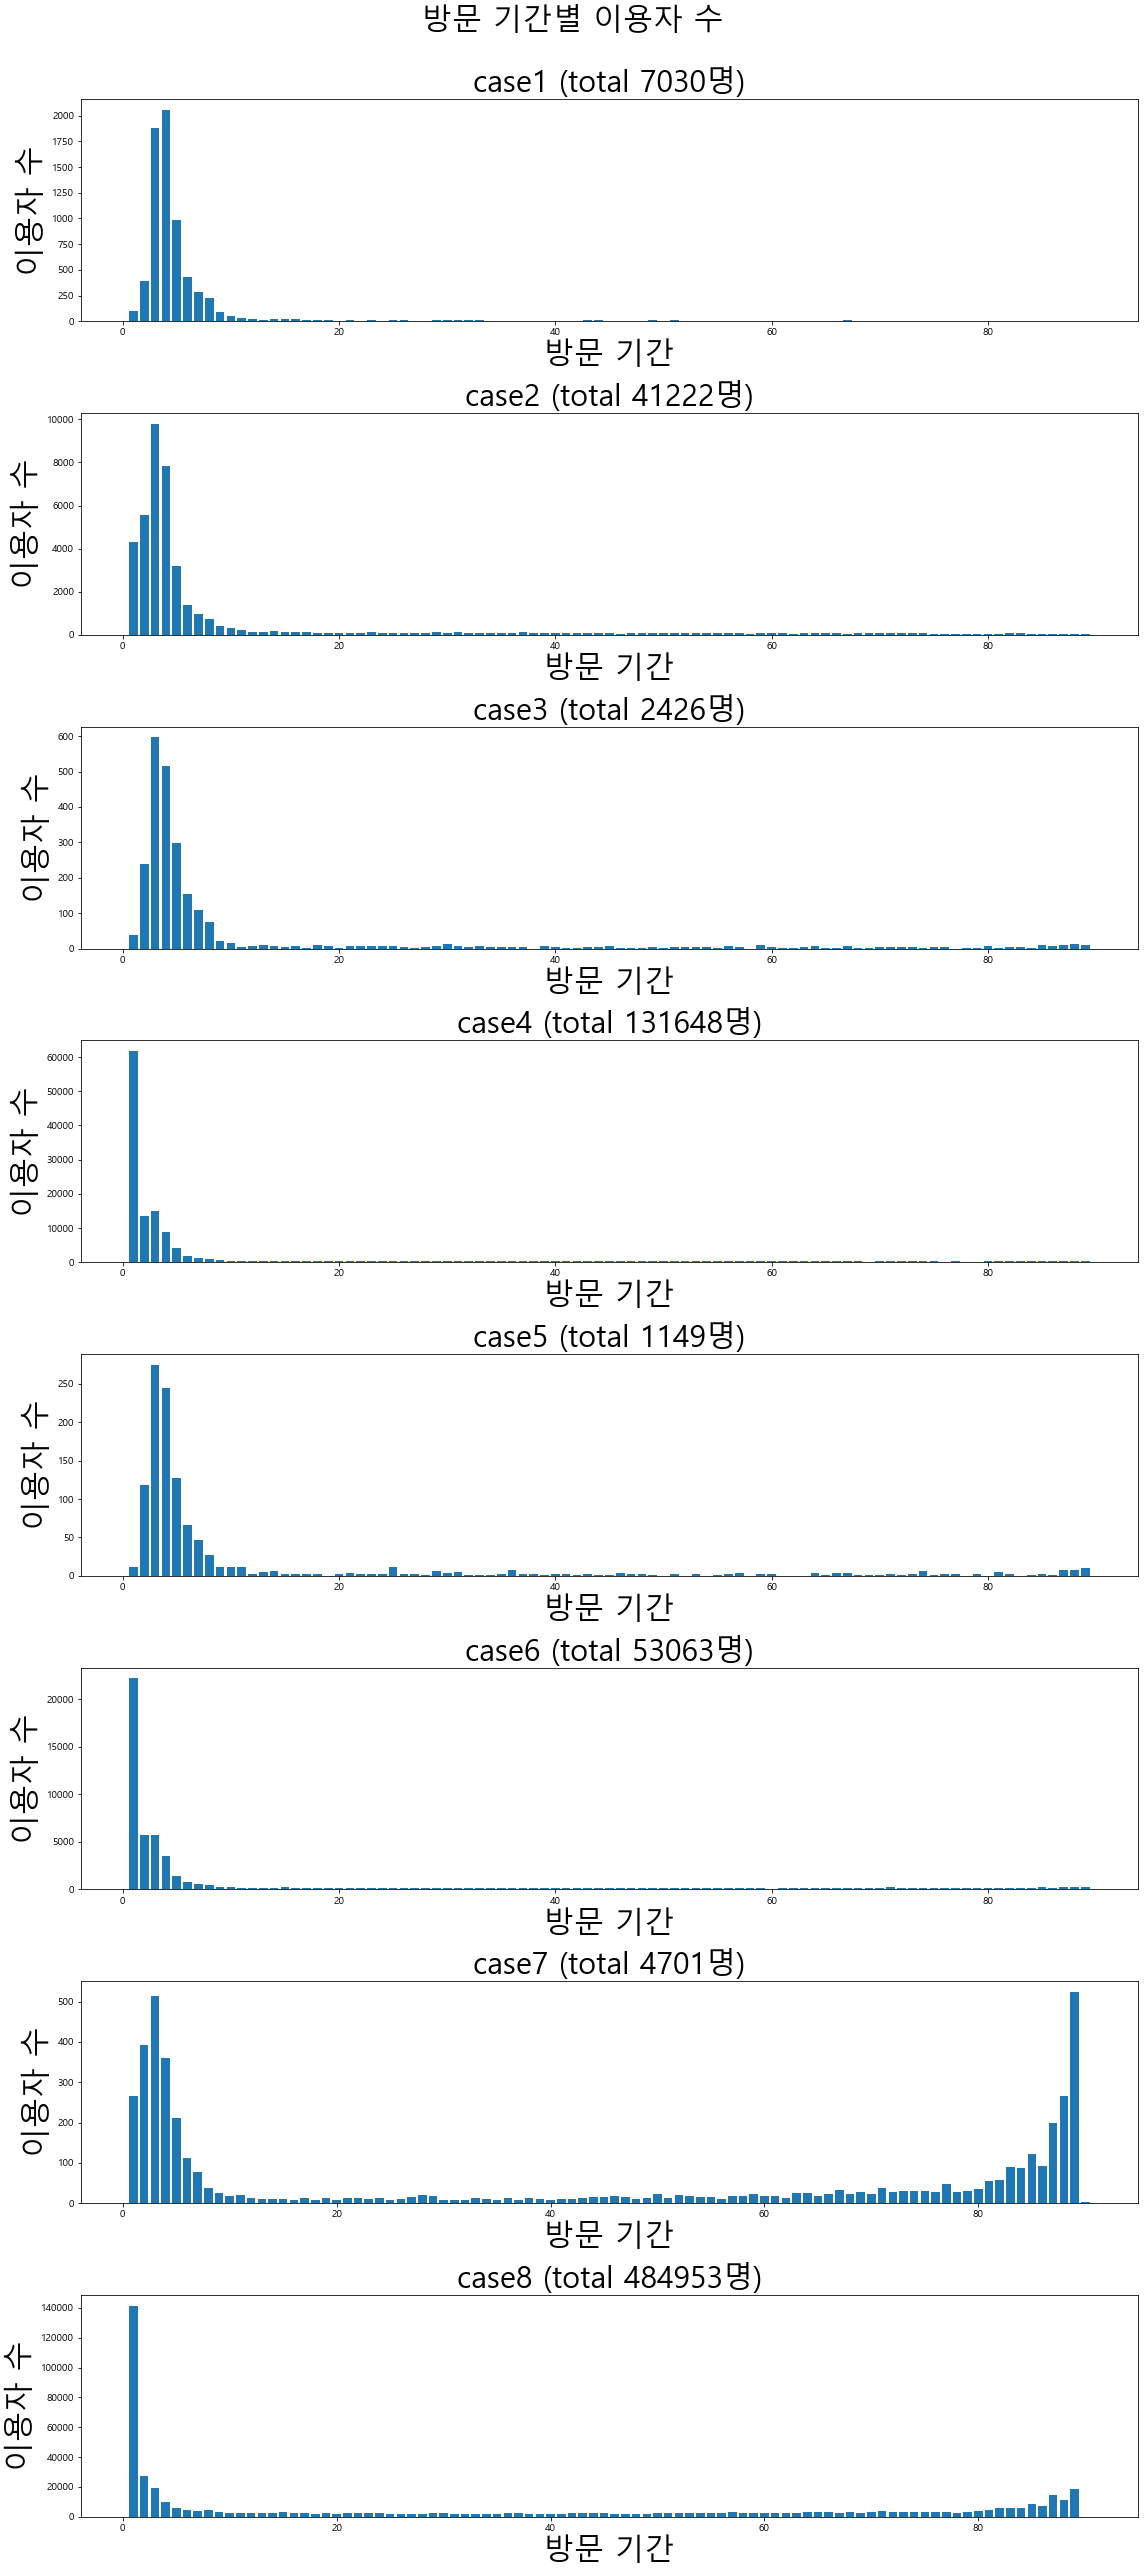

In [23]:
anz.draw_period_user_per_case(user_df)

### 3-3) 알고리즘 검증 - period검증

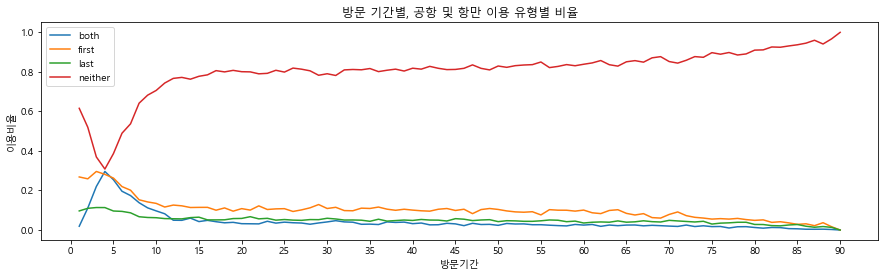

In [24]:
plt = anz.draw_period_analysis_graph(user_df)
plt.show()

### 3-4) 알고리즘 검증 - usage_ratio검증

   both 이용자수 = ( 90%미만:  22853명,  90%이상:  25399명)
  first 이용자수 = ( 90%미만:  40955명,  90%이상:  93119명)
   last 이용자수 = ( 90%미만:  18913명,  90%이상:  35299명)
neither 이용자수 = ( 90%미만: 300097명,  90%이상: 189557명)


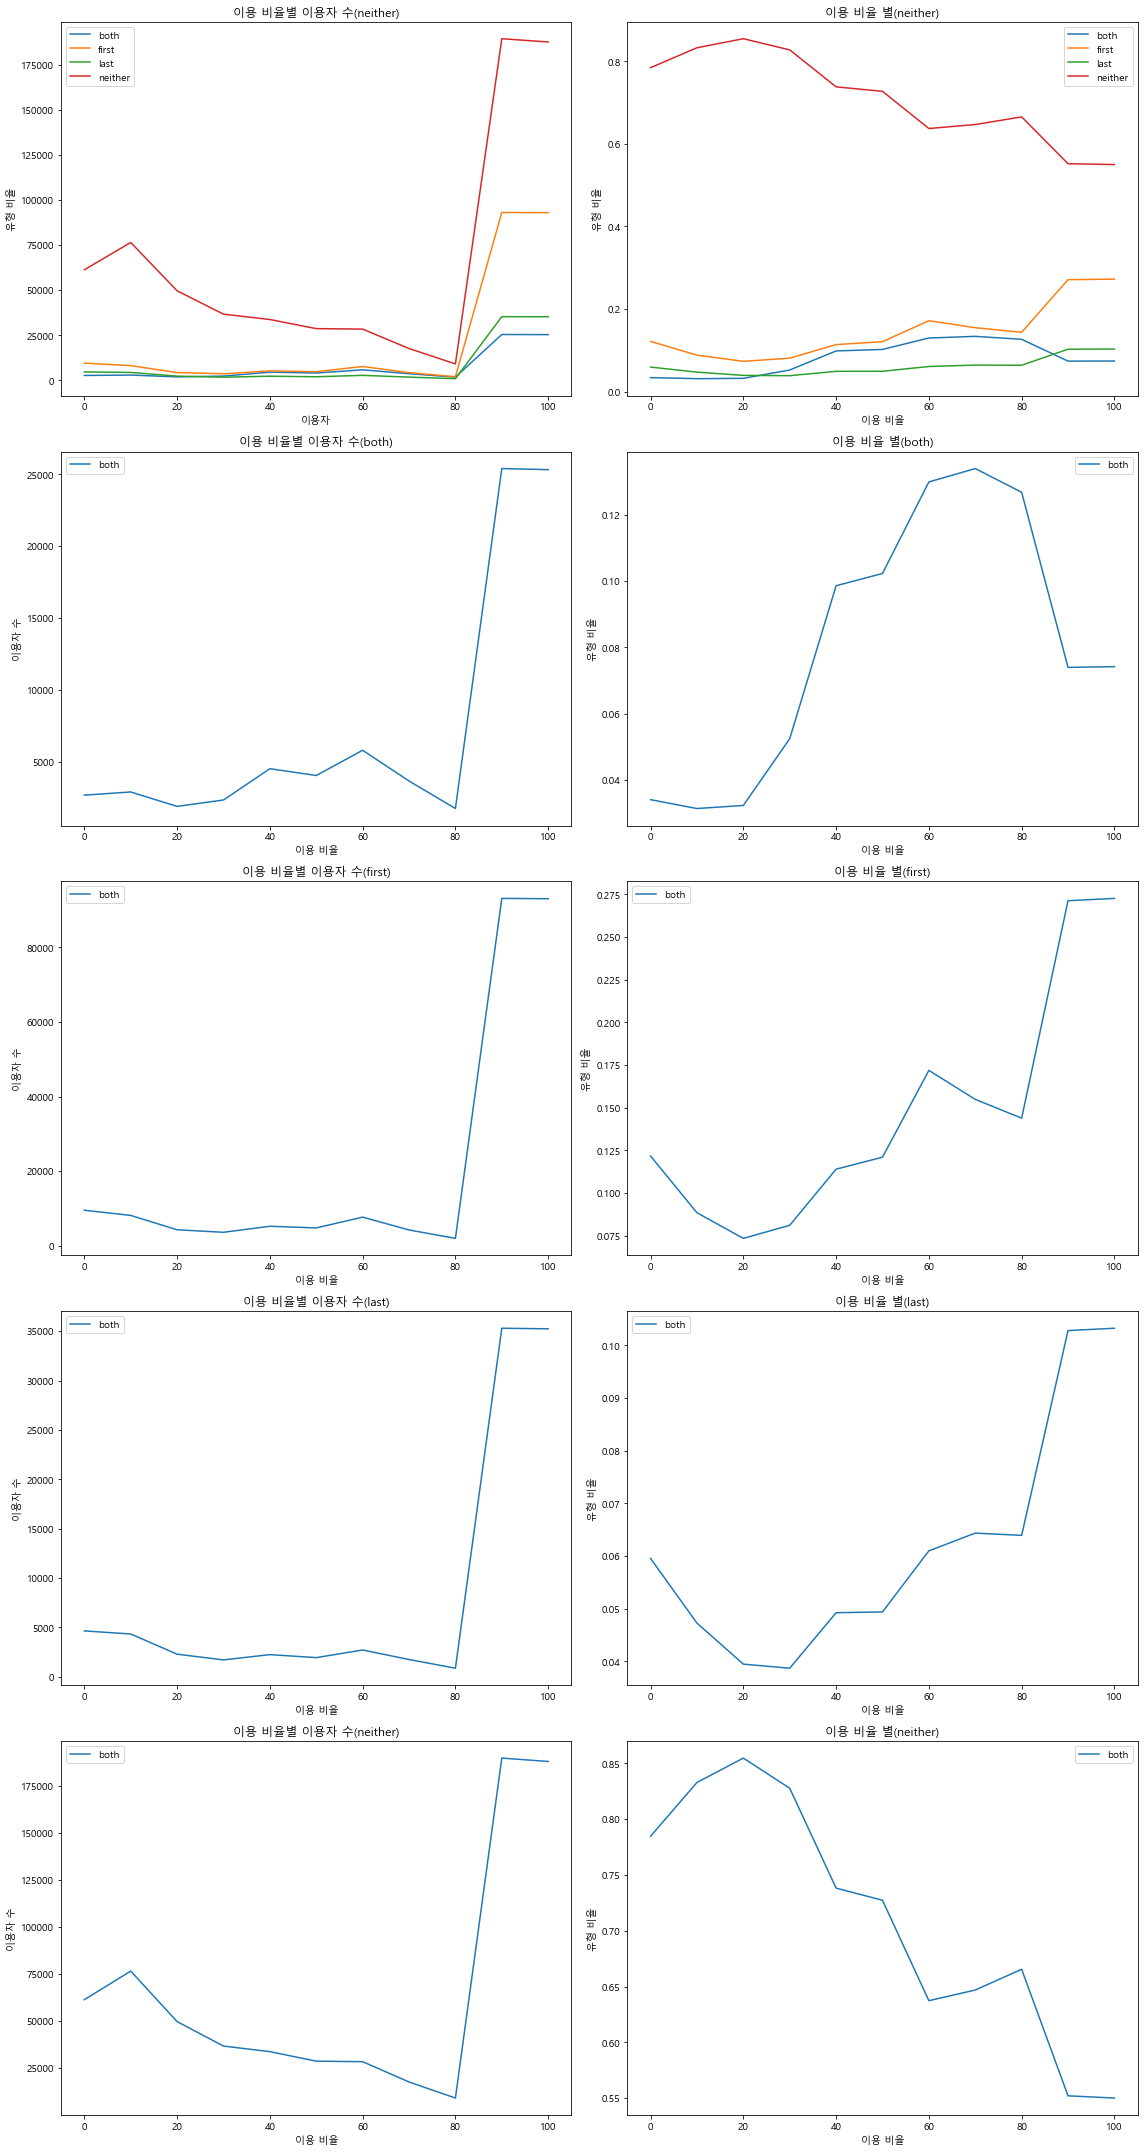

In [25]:
columns = ['both', 'first', 'last', 'neither']
boundary = 90
for column in columns:
    down = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] < boundary)])
    up = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] >= boundary)])
    print("%7s 이용자수 = (%3d%%미만: %6d명, %3d%%이상: %6d명)" % (column, boundary, down, boundary, up))
plt = anz.draw_usage_ratio_analysis_graph(user_df)
plt.show()

# 4. 결과 출력 

### 3-1) 이용자 출력

In [26]:
user_df

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first_station,last_station,both,first,last,neither,tour_visit,case,tourist
129,60126bd03aab52274cd4e09f6432ab960d49545a699ef3...,2019-06-01,2019-06-03,2,3,9,66,airport,airport,True,False,False,False,2.0,1,True
1857,67b5aff10e2b979c1da4e125e0f47f405857a12883c44b...,2019-06-01,2019-06-02,2,2,9,100,airport,airport,True,False,False,False,2.0,1,True
2251,879541bcca73469aa71daf6ce5c22df2af19a6ae9f775f...,2019-06-01,2019-08-23,26,84,47,30,airport,airport,True,False,False,False,1.0,1,False
2278,af4d652be324b8553112236b71cacd2eaa940ba896ba30...,2019-06-01,2019-06-04,4,4,21,100,airport,airport,True,False,False,False,2.0,1,True
2483,571d1c70903db31339226b0cf80a6e3fcf605c8c4a4ade...,2019-06-01,2019-06-26,13,26,36,50,harbor,airport,True,False,False,False,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726186,c1b9568d0352a747567ffc1eeb6c773f6d7a5c40b0f25e...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726187,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726188,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726189,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,2019-08-29,2019-08-29,1,1,1,100,other,other,False,False,False,True,0.0,8,False


### 3-2) 정류장 출력

In [27]:
station_df

,station_id,station_name,station_longitude,station_latitude,station_address,tour_geton_usage,regident_geton_usage,tour_getoff_usage,regident_getoff_usage,total_usage
3042,3271.0,제주시청(광양방면),126.53035,33.49892,제주특별자치도 제주시 이도이동 1938-1,1981.0,241714.0,1287.0,143835.0,388817.0
3041,3270.0,제주시청(아라방면),126.52977,33.49956,제주특별자치도 제주시 이도이동 1772-31,1491.0,193802.0,2160.0,160073.0,357526.0
334,357.0,한라병원,126.48508,33.48944,제주특별자치도 제주시 연동 2335-4,1275.0,137976.0,1000.0,86511.0,226762.0
335,358.0,한라병원,126.48600,33.48963,제주특별자치도 제주시 연동 251-66,1183.0,121324.0,1251.0,84701.0,208459.0
604,638.0,제주국제공항(구제주방면),126.49345,33.50661,제주특별자치도 제주시 용담이동 1462-1,10005.0,132228.0,5277.0,50603.0,198113.0
...,...,...,...,...,...,...,...,...,...,...
2505,2680.0,수산1리노인회관,126.88266,33.44670,제주특별자치도 서귀포시 성산읍 수산리 1199-1,0.0,1.0,0.0,0.0,1.0
1217,1309.0,이시돌상단지,126.33733,33.35975,제주특별자치도 제주시 한림읍 금악리 198-60,0.0,0.0,0.0,1.0,1.0
3459,4105.0,이스트힐스,126.63344,33.48146,제주특별자치도 제주시 회천동 229-3,0.0,1.0,0.0,0.0,1.0
1198,1285.0,하가삼거리,126.34830,33.45587,제주특별자치도 제주시 애월읍 하가리 1369-5,0.0,0.0,0.0,1.0,1.0


### 3-3) 방문기간 별 관광객 수 출력

<module 'matplotlib.pyplot' from 'C:\\Users\\hooni\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

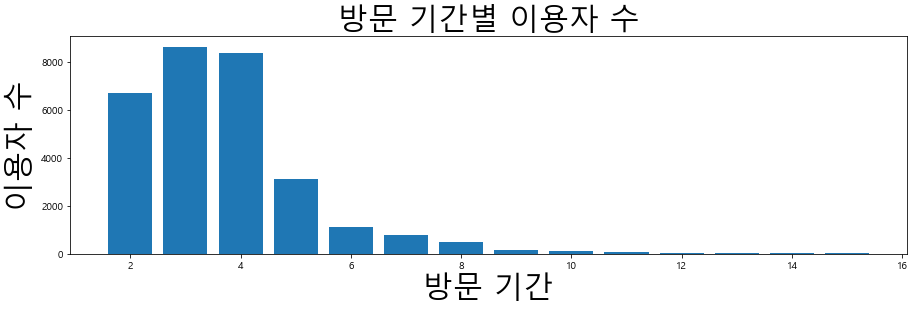

In [28]:
df = user_df[user_df["tourist"] == True]
anz.draw_period_user(plt, df)

### 3-1) both 관광객 출력

In [29]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['both'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 200)

<ipython-input-29-da876e3d4890>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['both'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1420849,20190610,2019-06-10 19:29:27,"제주국제공항(대정,화순,일주서로)",2019-06-10 19:59:03,애월환승정류장(애월리),1
1420848,20190610,2019-06-10 20:00:54,애월환승정류장(애월리),2019-06-10 20:01:40,한담동,1
1576756,20190611,2019-06-11 13:26:07,곽지해수욕장,2019-06-11 13:46:56,옹포사거리,1
1576755,20190611,2019-06-11 17:12:43,협재해수욕장,2019-06-11 17:39:23,한담동,1
1602029,20190612,2019-06-12 11:36:25,한담동,2019-06-12 12:35:08,서문시장,1
1602028,20190612,2019-06-12 14:40:17,관덕정,2019-06-12 15:00:48,이호테우해수욕장,1
1602031,20190612,2019-06-12 15:50:21,오광로입구,2019-06-12 16:23:59,곽지해수욕장,1
1602030,20190612,2019-06-12 17:20:05,곽지해수욕장,2019-06-12 18:35:13,서문시장,1
12724,20190613,2019-06-13 07:00:53,관덕정,2019-06-13 07:06:03,제주국제공항(신제주방면),1


### 3-2) first 관광객 출력

In [30]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['first'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 200)

<ipython-input-30-24ff40b1a0e1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['first'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1523314,20190611,2019-06-11 21:29:42,제주국제공항(구제주방면),2019-06-11 21:41:58,남서광마을입구,1
1646584,20190612,2019-06-12 10:02:53,제주국제공항(구제주방면),2019-06-12 10:14:04,관덕정,1
1646585,20190612,2019-06-12 15:24:51,한담동,2019-06-12 16:48:31,산방산,1
1646583,20190612,2019-06-12 17:50:42,산방산,2019-06-12 18:36:58,진부동,1
56042,20190613,2019-06-13 10:37:18,동문로터리(동문시장),2019-06-13 10:43:20,우당도서관입구,1
56040,20190613,2019-06-13 10:54:56,6호광장,2019-06-13 11:54:45,성산항,1
56044,20190613,2019-06-13 16:24:18,성산항,2019-06-13 16:32:49,성산일출봉입구,1
56043,20190613,2019-06-13 19:13:16,성산일출봉입구,2019-06-13 19:43:19,월정리,1
56041,20190613,2019-06-13 20:47:35,월정리,2019-06-13 21:38:59,제일교동문시장입구,1


### 3-3) last 관광객 출력

In [31]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['last'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 100)

<ipython-input-31-0538c16b190b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['last'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1384136,20190610,2019-06-10 19:28:46,중문관광단지,2019-06-10 20:07:08,솔동산입구,4
1548287,20190611,2019-06-11 09:21:52,동문로터리,2019-06-11 09:54:27,성판악,5
1548288,20190611,2019-06-11 17:38:33,성판악,2019-06-11 18:07:53,동문로터리,1
1741453,20190612,2019-06-12 10:01:54,서귀포항,NaT,NaN,1
56116,20190613,2019-06-13 08:46:31,은남동,2019-06-13 08:58:51,제주버스터미널,5
56113,20190613,2019-06-13 09:20:01,제주버스터미널,2019-06-13 10:39:30,성산항,5
56114,20190613,2019-06-13 17:02:34,성산항,2019-06-13 18:26:19,제주버스터미널,5
56115,20190613,2019-06-13 18:32:56,제주버스터미널,2019-06-13 18:46:49,은남동,5
273518,20190614,2019-06-14 11:55:27,메종글래드제주,NaT,NaN,1
273517,20190614,2019-06-14 11:55:41,메종글래드제주,2019-06-14 12:07:02,제주국제공항(구제주방면),4


### 3-4) neither 관광객 출력

In [32]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['neither'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 150)

<ipython-input-32-9fc015b0b5a4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['neither'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
675738,20190605,2019-06-05 18:53:45,서문시장,2019-06-05 19:04:47,일도2동주민센터,1
675739,20190605,2019-06-05 20:41:05,제주여자상업고등학교,2019-06-05 20:55:47,화물청사입구,1
832209,20190606,2019-06-06 12:04:01,시외버스출발지(가상정류소),2019-06-06 13:50:32,성산일출봉입구,1
832213,20190606,2019-06-06 14:46:08,성산일출봉입구,2019-06-06 15:01:51,신양리입구,1
832215,20190606,2019-06-06 16:34:15,섭지코지,2019-06-06 16:39:47,고성리제주은행,1
832210,20190606,2019-06-06 16:42:21,고성리제주은행,2019-06-06 17:21:47,만장굴입구,1
832214,20190606,2019-06-06 17:45:05,만장굴입구,2019-06-06 17:48:38,행원목장,1
832211,20190606,2019-06-06 19:07:53,김녕미로공원,2019-06-06 19:11:37,만장굴입구,1
832216,20190606,2019-06-06 19:24:08,만장굴입구,2019-06-06 20:21:08,광양사거리,1
832212,20190606,2019-06-06 22:59:44,광양사거리,2019-06-06 23:04:26,제주버스터미널(종점),1
